In [5]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
columns = [f"f{i}" for i in range(34)] + ["label"]
df = pd.read_csv(url, header=None, names=columns)

X = df.iloc[:, :-1].values
y_raw = df["label"].values
y = (y_raw == 'b').astype(int)  # 'b' = anomalie, 'g' = normalne

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_samples = trial.suggest_float("max_samples", 0.2, 1.0)
    contamination = trial.suggest_float("contamination", 0.01, 0.2)
    max_features = trial.suggest_float("max_features", 0.3, 1.0)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        contamination=contamination,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train)
    y_pred = model.predict(X_val)
    y_pred = (y_pred == -1).astype(int)

    return f1_score(y_val, y_pred)


study = optuna.create_study(
    direction="maximize",
    study_name="iforest_ionosphere",
    storage="sqlite:///iforest_ionosphere.db",
    load_if_exists=True
)
study.optimize(objective, n_trials=200)

print("Best score:", study.best_value)
print("Best params:", study.best_params)


[I 2025-05-15 11:08:11,132] Using an existing study with name 'iforest_ionosphere' instead of creating a new one.
[I 2025-05-15 11:08:13,395] Trial 1 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 359, 'max_samples': 0.8761444872042756, 'contamination': 0.10021917062994845, 'max_features': 0.7917555369555768, 'bootstrap': True}. Best is trial 1 with value: 0.48484848484848486.
[I 2025-05-15 11:08:15,212] Trial 2 finished with value: 0.3870967741935484 and parameters: {'n_estimators': 285, 'max_samples': 0.6539170748079364, 'contamination': 0.05272092482499003, 'max_features': 0.7818070289189806, 'bootstrap': False}. Best is trial 1 with value: 0.48484848484848486.
[I 2025-05-15 11:08:16,487] Trial 3 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 206, 'max_samples': 0.4467544040669658, 'contamination': 0.12547534514384437, 'max_features': 0.4943565704989282, 'bootstrap': False}. Best is trial 1 with value: 0.48484848484848486.
[I 202

Best score: 0.6486486486486487
Best params: {'n_estimators': 128, 'max_samples': 0.8834294960078559, 'contamination': 0.19197787485947843, 'max_features': 0.30113608097697614, 'bootstrap': False}


In [ ]:
import optuna
from sklearn.tree import DecisionTreeRegressor


study = optuna.load_study(study_name="iforest_ionosphere", storage="sqlite:///iforest_ionosphere.db")


df = study.trials_dataframe()


df = df[df["state"] == "COMPLETE"]


df_model = df.drop(columns=["number", "state", "datetime_start", "datetime_complete", "duration"])
df_model = df_model.dropna(axis=1, how='all')
df_model = df_model.dropna()
print(df_model)

X = df_model.drop(columns=["value"])
y = df_model["value"]
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X, y)


In [22]:
importances = tree.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


params_bootstrap: 0.0000
params_contamination: 0.9158
params_max_features: 0.0183
params_max_samples: 0.0204
params_n_estimators: 0.0456


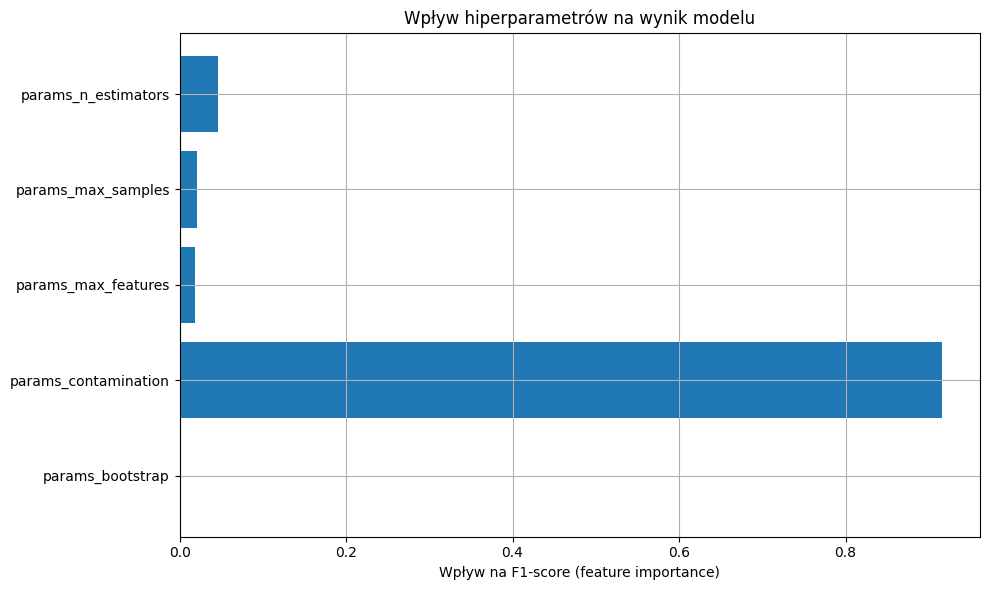

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel("Wpływ na F1-score (feature importance)")
plt.title("Wpływ hiperparametrów na wynik modelu")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
columns = [f"f{i}" for i in range(34)] + ["label"]
df = pd.read_csv(url, header=None, names=columns)

X = df.iloc[:, :-1].values
y_raw = df["label"].values
y = (y_raw == 'b').astype(int)  # 1 = anomalia (bad), 0 = normalna (good)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)



def objective(trial):
    model_name = trial.suggest_categorical("model", ["IsolationForest", "OneClassSVM", "EllipticEnvelope", "LOF"])

    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    max_samples = trial.suggest_float("max_samples", 0.1, 1.0)
    contamination = trial.suggest_float("contamination", 0.01, 0.5)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    kernel = trial.suggest_categorical("kernel", ["rbf", "sigmoid", "poly"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    nu = trial.suggest_float("nu", 0.01, 0.5)

    support_fraction = trial.suggest_float("support_fraction", 0.1, 1.0)

    n_neighbors = trial.suggest_int("n_neighbors", 10, 100)


    if model_name == "IsolationForest":
        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42, n_jobs=-1
        )
    elif model_name == "OneClassSVM":
        model = OneClassSVM(
            kernel=kernel,
            gamma=gamma,
            nu=nu
        )
    elif model_name == "EllipticEnvelope":
        model = EllipticEnvelope(
            contamination=contamination,
            support_fraction=support_fraction,
            random_state=42
        )
    elif model_name == "LOF":
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True,
            n_jobs=-1
        )
    else:
        raise ValueError("Nieznany model")

    model.fit(X_train)
    y_pred = model.predict(X_val)
    y_pred = (y_pred == -1).astype(int)

    return f1_score(y_val, y_pred)


study = optuna.create_study(
    direction="maximize",
    study_name="multi_model_outlier_study_3",
    storage="sqlite:///multi_model_outliers_3.db",
    load_if_exists=True
)
study.optimize(objective, n_trials=1000)


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

[I 2025-05-15 22:24:42,353] A new study created in RDB with name: multi_model_outlier_study_3
/home/pawel/anaconda3/envs/AI/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
[I 2025-05-15 22:24:43,612] Trial 0 finished with value: 0.48484848484848486 and parameters: {'model': 'EllipticEnvelope', 'n_estimators': 229, 'max_samples': 0.9175353648743605, 'contamination': 0.11479435505694757, 'max_features': 0.8325907910447286, 'bootstrap': True, 'kernel': 'sigmoid', 'gamma': 'scale', 'nu': 0.09980492035743642, 'support_fraction': 0.9360475924511346, 'n_neighbors': 96}. Best is trial 0 with value: 0.48484848484848486.
/home/pawel/anaconda3/envs/AI/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
[I 2025-05-15 22:24:44,858] Trial 1 finished with value: 

In [2]:
import optuna
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

study = optuna.load_study(study_name="multi_model_outlier_study_3", storage="sqlite:///multi_model_outliers_3.db")
df = study.trials_dataframe()

df = df[df["state"] == "COMPLETE"]

df_model = df[[col for col in df.columns if col.startswith("params_")] + ["value"]]

categorical_cols = [col for col in df_model.columns if df_model[col].dtype == "object"]
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)


X = df_model.drop(columns=["value"])
y = df_model["value"]


tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X, y)



DecisionTreeRegressor(max_depth=4, random_state=42)

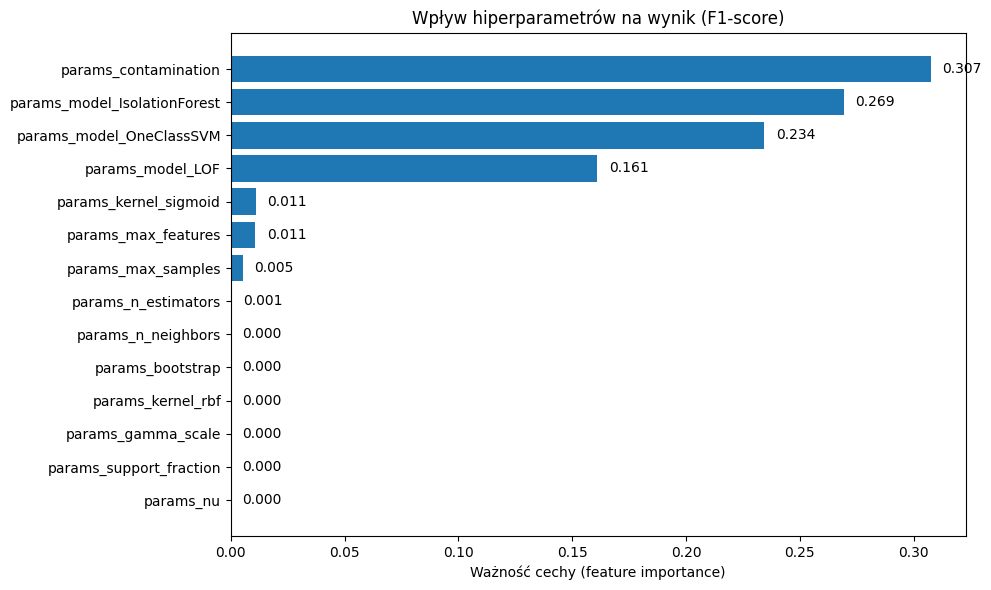

In [3]:
importances = tree.feature_importances_

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df["feature"], importance_df["importance"])


for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}", va='center')

plt.xlabel("Ważność cechy (feature importance)")
plt.title("Wpływ hiperparametrów na wynik (F1-score)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



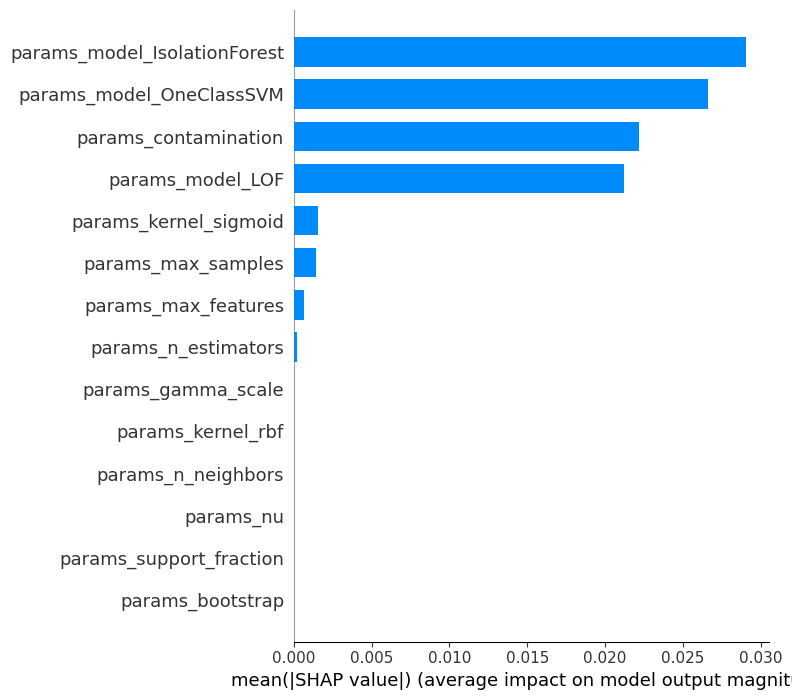

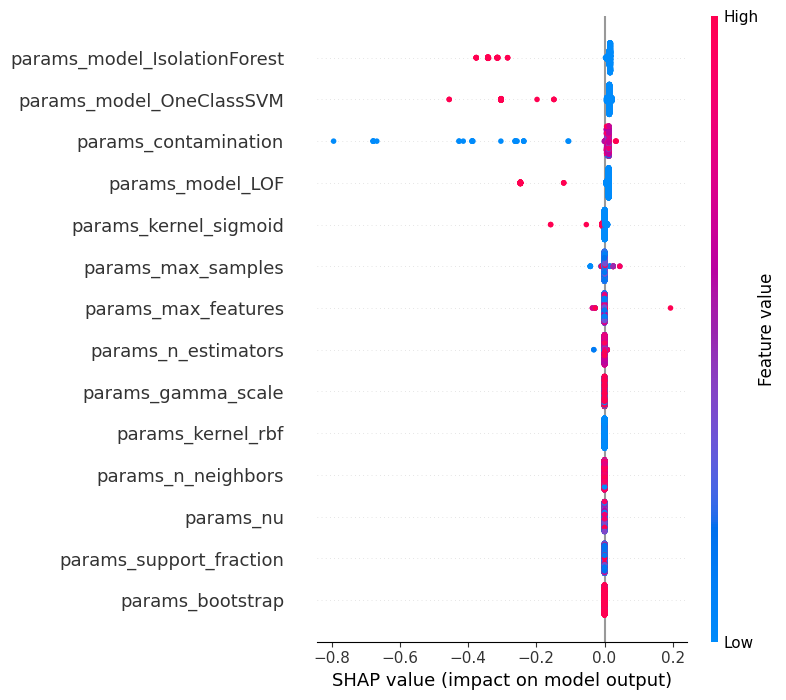

In [4]:
import shap
explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)


C:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-30 08:51:02,245] Using an existing study with name 'multi_model_outlier_study_5' instead of creating a new one.
C:\Users\pawel\Machine-Learning\.venv\Lib\site-packages\sklearn\covariance\_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
[I 2025-05-30 08:51:02,525] Trial 300 finished with value: 0.9361702127659575 and parameters: {'model': 'EllipticEnvelope', 'contamination': 0.3038440897536289, 'support_fraction': 0.9866136258717931}. Best is trial 13 with value: 0.9361702127659575.
C:\Users\pawel\Machine-Learning\.venv\Lib\site-packages\sklearn\covariance\_robust_covariance.py:749: UserWarning: The covariance matrix associated to

     params_contamination  params_max_features  params_max_samples  \
0                0.086449                  NaN                 NaN   
1                0.099868             0.488751            0.572281   
2                0.394736                  NaN                 NaN   
3                0.093557                  NaN                 NaN   
4                0.057859                  NaN                 NaN   
..                    ...                  ...                 ...   
595              0.310346             0.458204            0.157841   
596              0.336404                  NaN                 NaN   
597              0.287562                  NaN                 NaN   
598              0.364466                  NaN                 NaN   
599              0.299477                  NaN                 NaN   

     params_n_estimators  params_n_neighbors  params_nu  \
0                    NaN                 NaN   0.020086   
1                  159.0                 

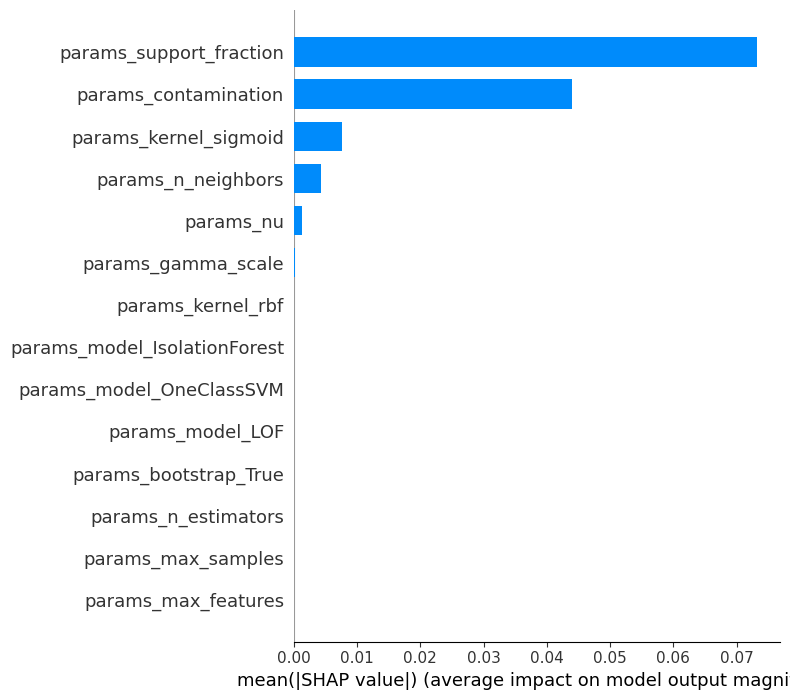

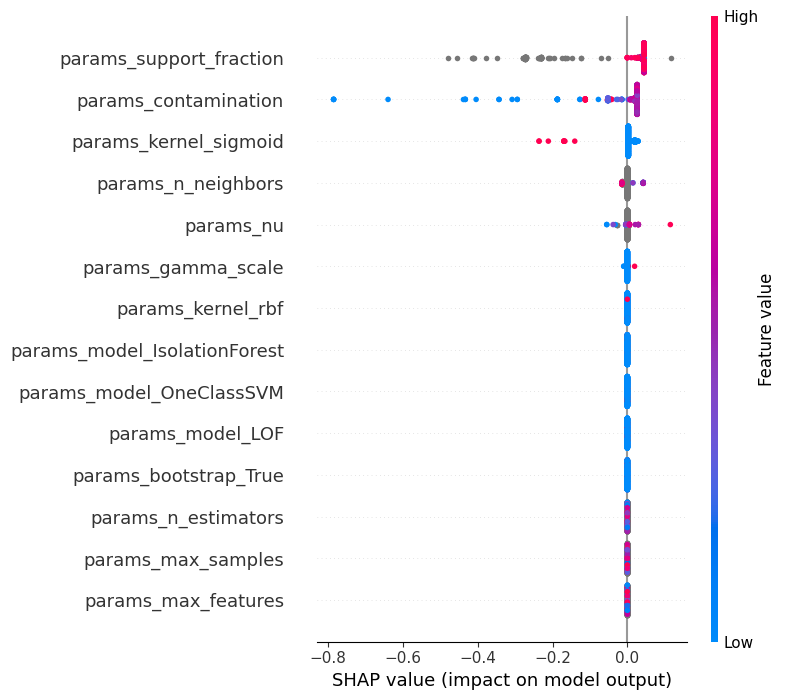

In [1]:
import optuna
from optuna.samplers import TPESampler  # sampler TPE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
import shap
import matplotlib.pyplot as plt

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
columns = [f"f{i}" for i in range(34)] + ["label"]
df = pd.read_csv(url, header=None, names=columns)

X = df.iloc[:, :-1].values
y = (df["label"].values == 'b').astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

def objective(trial):
    model_name = trial.suggest_categorical("model", ["IsolationForest", "OneClassSVM", "EllipticEnvelope", "LOF"])
    contamination = trial.suggest_float("contamination", 0.01, 0.5)
    if model_name == "IsolationForest":
        model = IsolationForest(
            n_estimators=trial.suggest_int("n_estimators", 10, 500),
            max_samples=trial.suggest_float("max_samples", 0.1, 1.0),
            max_features=trial.suggest_float("max_features", 0.1, 1.0),
            bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
            contamination=contamination,
            random_state=42, n_jobs=-1
        )
    elif model_name == "OneClassSVM":
        model = OneClassSVM(
            kernel=trial.suggest_categorical("kernel", ["rbf", "sigmoid", "poly"]),
            gamma=trial.suggest_categorical("gamma", ["scale", "auto"]),
            nu=trial.suggest_float("nu", 0.01, 0.5)
        )
    elif model_name == "EllipticEnvelope":
        model = EllipticEnvelope(
            contamination=contamination,
            support_fraction=trial.suggest_float("support_fraction", 0.1, 1.0),
            random_state=42
        )
    else:
        model = LocalOutlierFactor(
            n_neighbors=trial.suggest_int("n_neighbors", 10, 100),
            contamination=contamination,
            novelty=True,
            n_jobs=-1
        )

    model.fit(X_train)
    y_pred = model.predict(X_val)
    y_pred = (y_pred == -1).astype(int)
    return f1_score(y_val, y_pred)

sampler = TPESampler(seed=42)
study = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="multi_model_outlier_study_5",
    storage="sqlite:///multi_model_outliers_5.db",
    load_if_exists=True
)

study.optimize(objective, n_trials=300)


df_trials = study.trials_dataframe()
df_complete = df_trials[df_trials["state"] == "COMPLETE"].copy()


param_cols = [c for c in df_complete.columns if c.startswith("params_")]
df_model = df_complete[param_cols + ["value"]]


cats = [c for c in df_model.columns if df_model[c].dtype == "object"]
df_model = pd.get_dummies(df_model, columns=cats, drop_first=True)
X_meta = df_model.drop(columns=["value"])
y_meta = df_model["value"]



tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X_meta, y_meta)
explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X_meta)
shap.summary_plot(shap_values, X_meta, plot_type="bar")
shap.summary_plot(shap_values, X_meta)
plt.show()


In [2]:
!pip install optuna-dashboard


  Obtaining dependency information for optuna-dashboard from https://files.pythonhosted.org/packages/fa/4a/3c55b8c49d0d096a8e97674fd505aaf38f9f3c743b2f89b8ca198210eb1f/optuna_dashboard-0.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for bottle>=0.13.0 from https://files.pythonhosted.org/packages/7b/b1/a6d4ef30ebfa0f62aedd437d81130075afc32266f7f6baf2cddf4b41ac2a/bottle-0.13.3-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.4 MB 682.7 kB/s eta 0:00:13
   ---------------------------------------- 0.1/8.4 MB 825.8 kB/s eta 0:00:11
    --------------------------------------- 0.2/8.4 MB 1.8 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/8.4 MB 3.5 MB/s eta 0:00:03
   ----- ---------------------------------- 1.2/8.4 MB 5.7 MB/s eta 0:00:02
   --------- ------------------------------ 1.9/8.4 MB 7.7 MB/s eta 0:00:01
   ------------ ---------------------------


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
